In [1]:
from DRL.constraints_code.parser import parse_constraints_file
from DRL.constraints_code.feature_orderings import set_ordering
from DRL.constraints_code.compute_sets_of_constraints import compute_sets_of_constraints
import torch
import pandas as pd
import torch.nn as nn
from DRL.constraints_code.correct_predictions import correct_preds, check_all_constraints_sat

import random
import numpy as np
from sklearn.model_selection import train_test_split

def seed_everything(seed: int):
    """Seed Python, NumPy, and PyTorch for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"All random seeds set to {seed}")


# Simple MLP Generator
class Generator(nn.Module):
    def __init__(self, input_dim=16, output_dim=32, hidden_dim=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, z):
        return self.model(z)

def sample(ordering_list, sets_of_constr, n = 10000):
    input_length = 20
    output_length = 10
    
    generator = Generator(input_dim=input_length, output_dim=output_length)
    noise = torch.rand(size=(n, input_length)).float() * 5 
    
    with torch.no_grad():
        generated_data = generator(noise)
        generated_data = generated_data.clone().detach()
    generated_data_orig = torch.tanh(generated_data * 3)/2 + 0.5
    print(generated_data.shape)
    print(generated_data[:10, :3])
    generated_data = correct_preds(generated_data_orig, ordering_list, sets_of_constr)
    
    sampled_data = generated_data.detach()

    return noise, sampled_data, generated_data_orig

seed = 1
constraint_path = "/Users/mihajlobulesnij/Documents/system/RAI/project/DRL_DGM/constraints_generated/smt_constraints/n10_r3.5999999999999996_i2.txt"
save_path = "/"

seed_everything(seed)

label_ordering = "predefined"


constraints_file = constraint_path
ordering, constraints = parse_constraints_file(constraints_file)
sets_of_constr = compute_sets_of_constraints(ordering, constraints, verbose=True)
noise, sampled_data, orig = sample(ordering, sets_of_constr)

All random seeds set to 1
 *** ALL CONSTRAINTS ***


100%|██████████| 8/8 [00:00<00:00, 32171.08it/s]


82


100%|██████████| 35/35 [00:00<00:00, 30782.27it/s]


267


100%|██████████| 65/65 [00:00<00:00, 1469.28it/s]


516


100%|██████████| 116/116 [00:00<00:00, 1924.19it/s]


580


100%|██████████| 284/284 [00:00<00:00, 670.24it/s]


401


100%|██████████| 168/168 [00:00<00:00, 1850.71it/s]


126


100%|██████████| 28/28 [00:00<00:00, 5845.72it/s]


35


100%|██████████| 12/12 [00:00<00:00, 42545.77it/s]


6


100%|██████████| 2/2 [00:00<00:00, 86480.49it/s]


0
--------------------------------------------------------------------------------
torch.Size([10000, 10])
tensor([[-0.1669, -0.3043,  0.0835],
        [-0.1045, -0.1521, -0.3787],
        [-0.0631, -0.3063, -0.1450],
        [ 0.0063, -0.0785, -0.0438],
        [-0.0939, -0.0751, -0.2659],
        [-0.0413, -0.4320, -0.2220],
        [-0.0890, -0.2340, -0.1345],
        [ 0.0476, -0.2296, -0.0464],
        [ 0.0566, -0.3175,  0.0520],
        [-0.0124, -0.3593, -0.1027]])
1
2
3
4
5
6
7
8
9
sum(0.45<corrected_preds[:0] < 0.55) tensor(2281)


In [5]:
from DRL.constraints_code.utils_functions import eval_atoms_list, check_all_constraints_are_sat, \
    compute_sat_stats, any_disjunctions_in_constraint_set, get_samples_violating_constraints
def get_constr_at_level_x(x, sets_of_constr):
    for var in sets_of_constr:
        if var.id == x.id:
            return sets_of_constr[var]
for x in ordering[1:2]:
    pos = x.id
    x_constr = get_constr_at_level_x(x, sets_of_constr)
    mask_samples_violating_req = get_samples_violating_constraints(x_constr, orig)
    print(sum(mask_samples_violating_req))

tensor(7820)


In [24]:
from z3 import parse_smt2_file, Real, RealVal, simplify, substitute

def check_vectors_against_smt2_z3(smt2_path, vectors):
    assertions = parse_smt2_file(smt2_path)
    var_names = [f"x{i+1}" for i in range(len(vectors[0]))]
    z3_vars = {name: Real(name) for name in var_names}
    results = []
    for vec in vectors:
        if len(vec) != len(var_names):
            raise ValueError(f"Vector length {len(vec)} does not match number of vars {len(var_names)}")
        subs = [(z3_vars[name], RealVal(float(val))) for name, val in zip(var_names, vec)]
        all_true = True
        for a in assertions:
            simplified = simplify(substitute(a, *subs))
            if simplified == False:
                all_true = False
                break

        results.append(all_true)
    return 1 - (sum(results)/len(results))

In [26]:
constraint_path = "/Users/mihajlobulesnij/Documents/system/RAI/project/DRL_DGM/constraints_generated/smt_constraints/n10_r3.5999999999999996_i2.smt2"
check_vectors_against_smt2_z3(constraint_path, orig)

1.0

(array([ 102.,  603., 1381., 1916., 2067., 1657., 1200.,  694.,  314.,
          66.]),
 array([0.09078419, 0.16600862, 0.24123307, 0.31645751, 0.39168194,
        0.46690637, 0.54213083, 0.61735523, 0.69257969, 0.76780409,
        0.84302855]),
 <BarContainer object of 10 artists>)

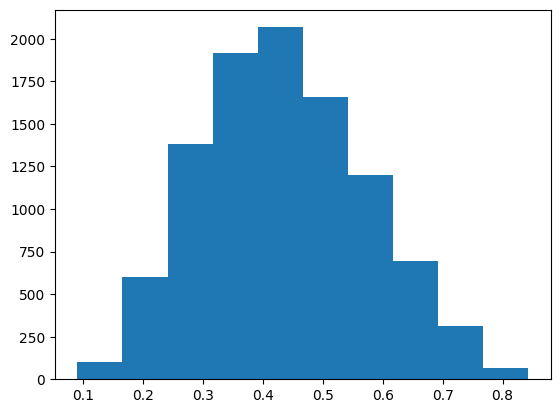

In [6]:
plt.hist(sampled_data[:, 0])

(array([2.530e+02, 5.670e+02, 5.240e+02, 3.550e+02, 2.050e+02, 1.110e+02,
        7.833e+03, 1.110e+02, 3.400e+01, 7.000e+00]),
 array([0.01555029, 0.09776451, 0.17997873, 0.26219296, 0.34440717,
        0.42662138, 0.50883561, 0.59104985, 0.67326403, 0.75547826,
        0.8376925 ]),
 <BarContainer object of 10 artists>)

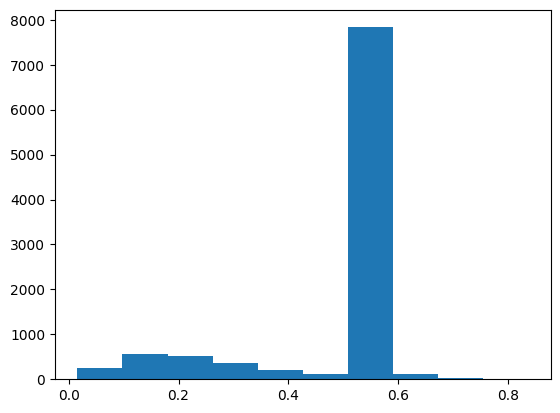

In [7]:
plt.hist(sampled_data[:, 1])

Text(0, 0.5, 'feature 1')

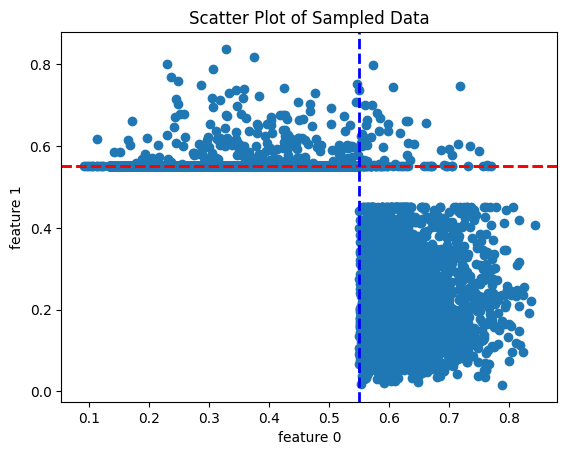

In [45]:
import matplotlib.pyplot as plt

# Example scatter plot
plt.scatter(sampled_data[:, 0], sampled_data[:, 1])

# Add title
plt.title("Scatter Plot of Sampled Data")

# Add horizontal line at y=0
plt.axhline(y=0.55, color='red', linestyle='--', linewidth=2)
plt.axhline(y=0.55, color='red', linestyle='--', linewidth=2)

# Add vertical line at x=0
plt.axvline(x=0.55, color='blue', linestyle='--', linewidth=2)

plt.xlabel("feature 0")
plt.ylabel("feature 1")
# Optional: add labels

Coefficient: [86.81798328]
Intercept: 51.834576638509425
MSE: 246.12179288664464
RMSE: 15.688269276330153


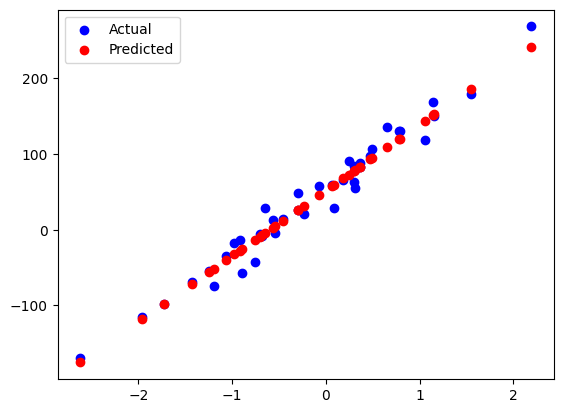

In [47]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Generate synthetic regression data
X, y = make_regression(
    n_samples=200,
    n_features=1,
    noise=15,
    bias=50,
    random_state=42
)

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Train model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict
y_pred = model.predict(X_test)

# 5. Metrics (compatible)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # manually compute RMSE

print("Coefficient:", model.coef_)
print("Intercept:", model.intercept_)
print("MSE:", mse)
print("RMSE:", rmse)

# 6. Plot
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.legend()
plt.show()


Text(0.5, 0, 'X-axis')

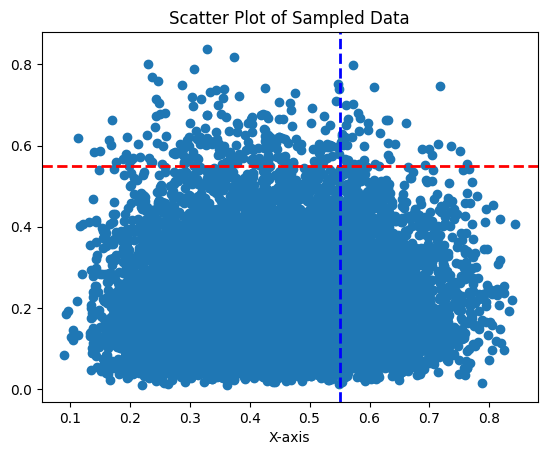

In [107]:
import matplotlib.pyplot as plt

# Example scatter plot
plt.scatter(orig[:, 0], orig[:, 1])

# Add title
plt.title("Scatter Plot of Sampled Data")

# Add horizontal line at y=0
plt.axhline(y=0.55, color='red', linestyle='--', linewidth=2)

# Add vertical line at x=0
plt.axvline(x=0.55, color='blue', linestyle='--', linewidth=2)

# Optional: add labels
plt.xlabel("X-axis")

In [50]:
!pip install python-sat


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.3 MB/s  0:00:01 eta 0:00:01


In [54]:
from pysat.formula import CNF
from pysat.solvers import Solver

cnf_file = "/Users/mihajlobulesnij/Documents/system/RAI/project/DRL_DGM/constraints_generated/sat_constraints/n10_r3.5999999999999996_i2.cnf"

formula = CNF(from_file=cnf_file)
solver = Solver(name='glucose4')
solver.append_formula(formula.clauses)

solutions = []

while solver.solve():
    model = solver.get_model()
    solutions.append(model)

    # Block the current model to get new ones
    blocking_clause = [-lit for lit in model]
    solver.add_clause(blocking_clause)

solver.delete()

print("Found", len(solutions), "solutions.")
for s in solutions:
    print(s)


Found 6 solutions.
[1, 2, 3, -4, -5, 6, -7, 8, 9, -10]
[1, 2, 3, -4, -5, -6, -7, -8, 9, -10]
[-1, 2, 3, -4, -5, -6, -7, -8, 9, -10]
[1, -2, -3, -4, 5, -6, 7, -8, 9, 10]
[1, -2, -3, -4, 5, -6, 7, 8, 9, 10]
[1, 2, 3, 4, -5, 6, -7, 8, 9, -10]


In [55]:
import numpy as np

# --- Define your constrained regions ---
regions = [
    [1, 2, 3, -4, -5, 6, -7, 8, 9, -10],
    [1, 2, 3, -4, -5, -6, -7, -8, 9, -10],
    [-1, 2, 3, -4, -5, -6, -7, -8, 9, -10],
    [1, -2, -3, -4, 5, -6, 7, -8, 9, 10],
    [1, -2, -3, -4, 5, -6, 7, 8, 9, 10],
    [1, 2, 3, 4, -5, 6, -7, 8, 9, -10]
]

# --- Parameters ---
LOW = 0.0
HI = 1.0
TH_LOW = 0.45
TH_HIGH = 0.55

# --- Function to sample y in a region ---
def sample_y_region(region, n_samples=200):
    """
    Sample y vectors inside a constrained region.
    """
    dim = len(region)
    Y = np.zeros((n_samples, dim))
    for i, s in enumerate(region):
        if s > 0:
            # Positive constraint: > 0.55
            Y[:, i] = np.random.uniform(TH_HIGH, HI, n_samples)
        else:
            # Negative constraint: < 0.45
            Y[:, i] = np.random.uniform(LOW, TH_LOW, n_samples)
    return Y

# --- Example: generate X randomly, Y according to regions ---
def generate_dataset(regions, samples_per_region=200, x_dim=5):
    """
    Generate X (real) and Y (10-D) dataset.
    X is sampled randomly, Y is constrained.
    """
    X_all = []
    Y_all = []

    for r in regions:
        # Sample X freely
        Xr = np.random.randn(samples_per_region, x_dim)

        # Sample Y constrained by the region
        Yr = sample_y_region(r, samples_per_region)

        X_all.append(Xr)
        Y_all.append(Yr)

    # Combine all regions
    X = np.vstack(X_all)
    Y = np.vstack(Y_all)

    return X, Y

# --- Generate dataset ---
X, Y = generate_dataset(regions, samples_per_region=300, x_dim=5)

print("X shape:", X.shape)   # (1800, 5)
print("Y shape:", Y.shape)   # (1800, 10)
print("Example Y rows:\n", Y[:5])


X shape: (1800, 5)
Y shape: (1800, 10)
Example Y rows:
 [[0.74143156 0.72584788 0.63132815 0.07423752 0.4343346  0.5921815
  0.18918091 0.94562684 0.99361802 0.32730842]
 [0.91482456 0.76025735 0.86243812 0.32725595 0.29372192 0.69309146
  0.14566024 0.59402764 0.97202424 0.06118261]
 [0.97384881 0.95281197 0.88851547 0.40082589 0.05792922 0.72153488
  0.27877056 0.6663673  0.60816313 0.10581136]
 [0.94145985 0.59975085 0.82798943 0.3864218  0.34736722 0.83472064
  0.38689338 0.57459527 0.94870909 0.22738763]
 [0.86679977 0.87901192 0.94563935 0.08291568 0.4282991  0.76218397
  0.2216882  0.65300134 0.61878796 0.16313335]]


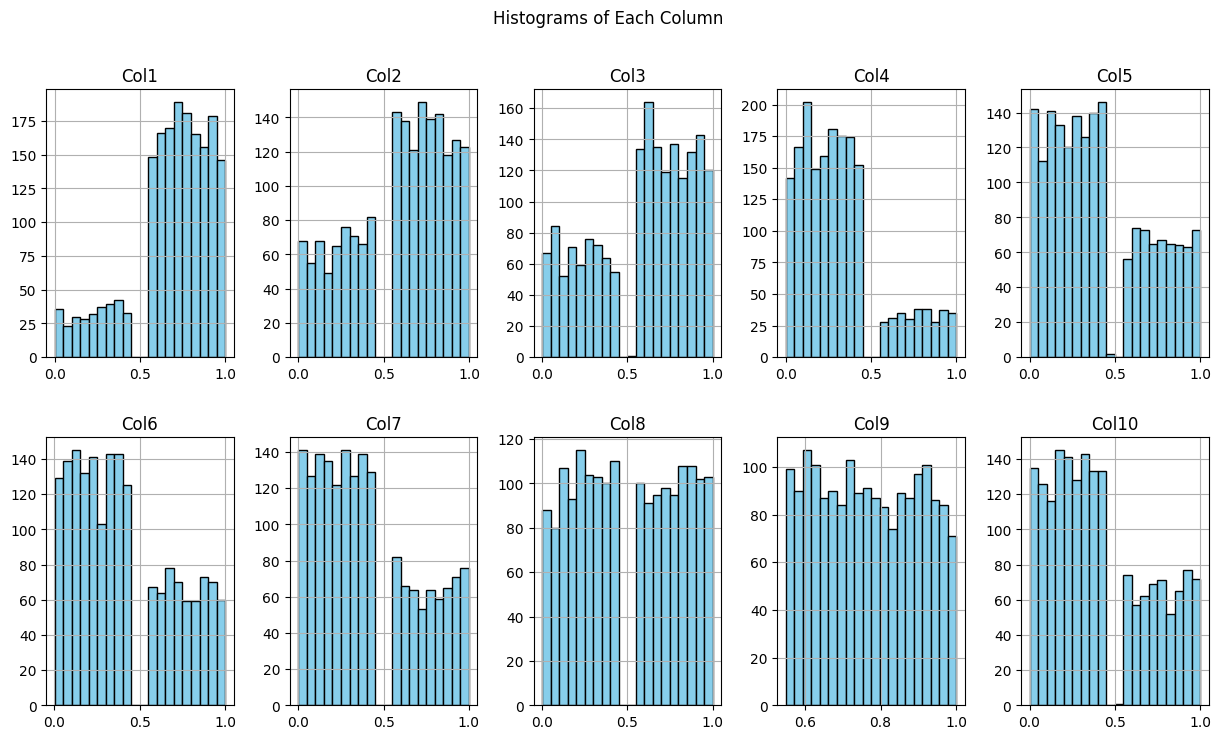

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert tensor to DataFrame
df = pd.DataFrame(Y, columns=[f'Col{i+1}' for i in range(Y.shape[1])])

# Plot histograms for each column
df.hist(bins=20, figsize=(15,8), layout=(2,5), color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Each Column")
plt.show()


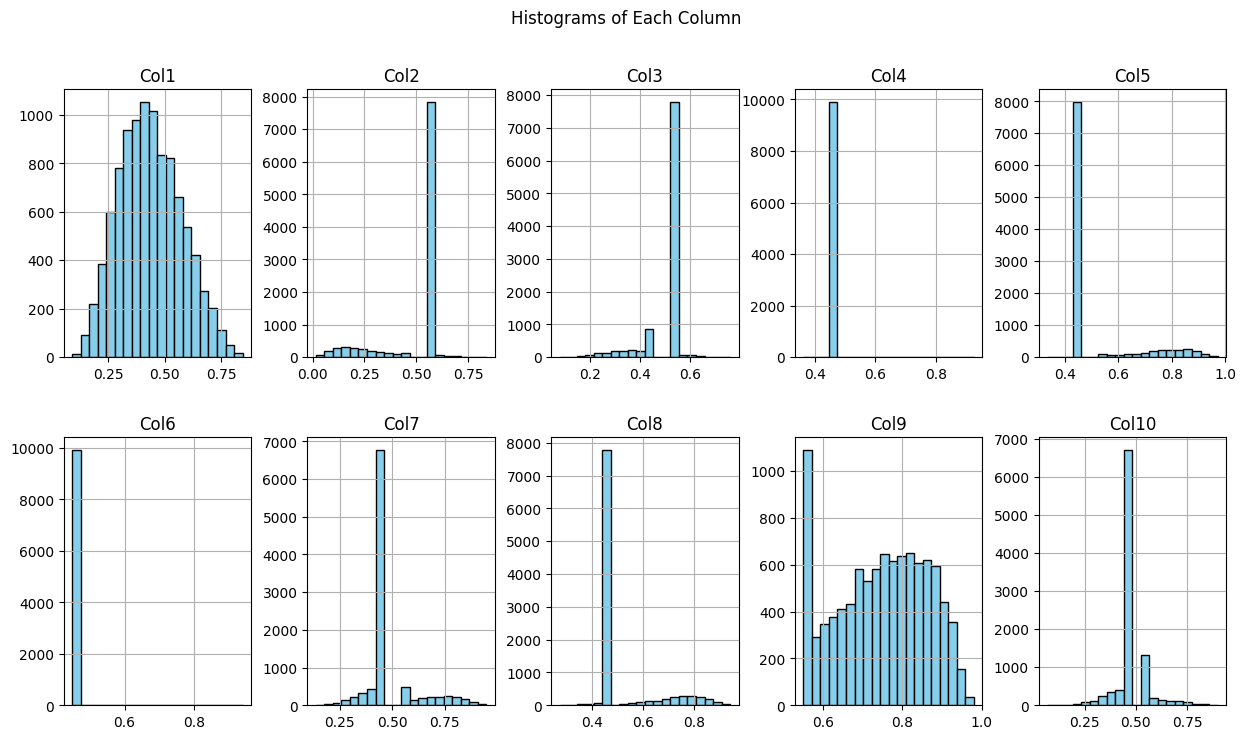

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert tensor to DataFrame
df = pd.DataFrame(sampled_data.numpy(), columns=[f'Col{i+1}' for i in range(sampled_data.shape[1])])

# Plot histograms for each column
df.hist(bins=20, figsize=(15,8), layout=(2,5), color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Each Column")
plt.show()


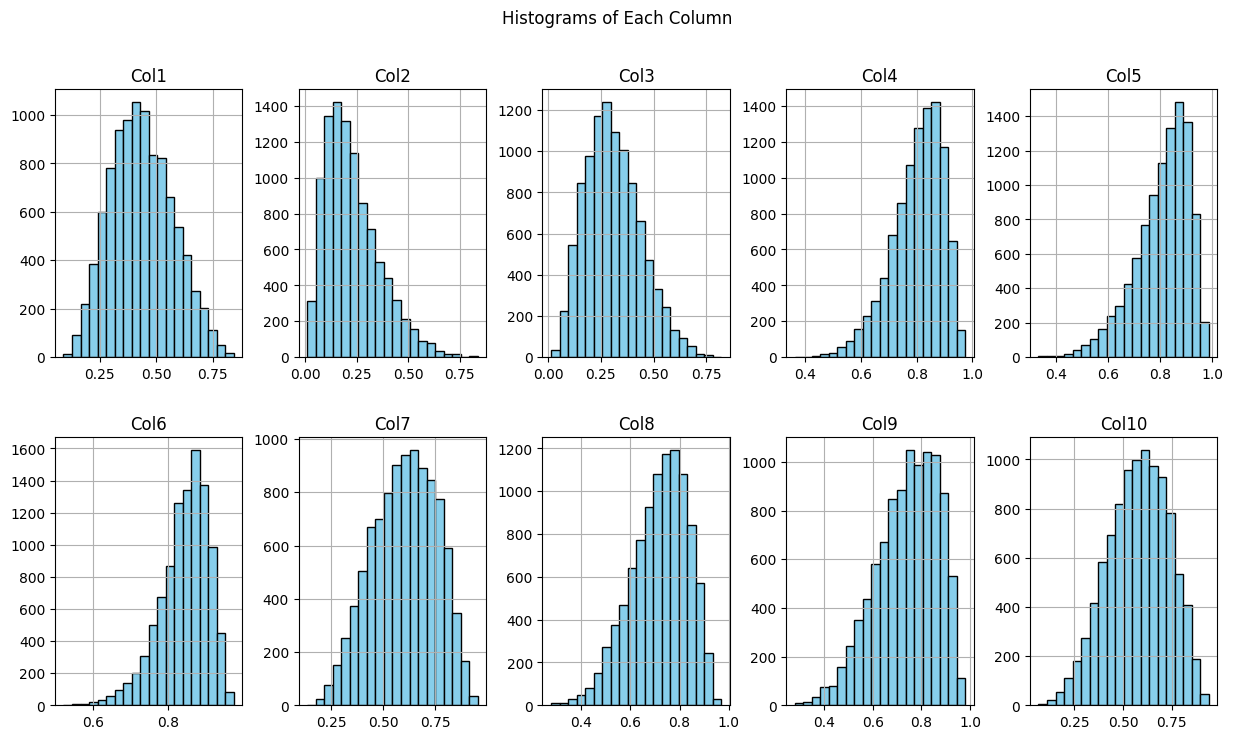

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert tensor to DataFrame
df = pd.DataFrame(orig.numpy(), columns=[f'Col{i+1}' for i in range(orig.shape[1])])

# Plot histograms for each column
df.hist(bins=20, figsize=(15,8), layout=(2,5), color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Each Column")
plt.show()
